<a href="https://colab.research.google.com/github/ArthurMor4is/t-xai/blob/main/fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fine-tuning for Image Classification with 🤗 Transformers**

This notebook shows how to fine-tune any pretrained Vision model for Image Classification on a custom dataset. The idea is to add a randomly initialized classification head on top of a pre-trained encoder, and fine-tune the model altogether on a labeled dataset.

## ImageFolder

This notebook leverages the [ImageFolder](https://huggingface.co/docs/datasets/v2.0.0/en/image_process#imagefolder) feature to easily run the notebook on a custom dataset. You can either load a `Dataset` from local folders or from local/remote files, like zip or tar.

## Any model

This notebook is built to run on any image classification dataset with any vision model checkpoint from the [Model Hub](https://huggingface.co/) as long as that model has a version with a Image Classification head, such as:
* [ViT](https://huggingface.co/docs/transformers/model_doc/vit#transformers.ViTForImageClassification)
* [Swin Transformer](https://huggingface.co/docs/transformers/model_doc/swin#transformers.SwinForImageClassification)
* [ConvNeXT](https://huggingface.co/docs/transformers/master/en/model_doc/convnext#transformers.ConvNextForImageClassification)

- in short, any model supported by [AutoModelForImageClassification](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForImageClassification).

## Data augmentation

This notebook leverages Torchvision's [transforms](https://pytorch.org/vision/stable/transforms.html) for applying data augmentation - note that we do provide alternative notebooks which leverage other libraries, including:

* [Albumentations](https://github.com/huggingface/notebooks/blob/main/examples/image_classification_albumentations.ipynb)
* [Kornia](https://github.com/huggingface/notebooks/blob/main/examples/image_classification_kornia.ipynb)
* [imgaug](https://github.com/huggingface/notebooks/blob/main/examples/image_classification_imgaug.ipynb).

---

Depending on the model and the GPU you are using, you might need to adjust the batch size to avoid out-of-memory errors. Set those two parameters, then the rest of the notebook should run smoothly.

[hub](https://huggingface.co/models?other=vision).

In [1]:
!pip install -q datasets transformers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.1/519.1 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.8 MB/s eta 0:00:00


In [2]:
pip show accelerate

Name: accelerate
Version: 0.21.0
Summary: Accelerate
Home-page: https://github.com/huggingface/accelerate
Author: The HuggingFace team
Author-email: sylvain@huggingface.co
License: Apache
Location: /usr/local/lib/python3.10/dist-packages
Requires: numpy, packaging, psutil, pyyaml, torch
Required-by: 


In [3]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

In [4]:
from huggingface_hub import notebook_login
from datasets import load_dataset
from datasets import load_metric
from transformers import AutoImageProcessor

notebook_login()

In [7]:
batch_size = 32 # batch size for training and evaluation

## Fine-tuning a model on an image classification task

### Loading the dataset

We will use the [🤗 Datasets](https://github.com/huggingface/datasets) library's [ImageFolder](https://huggingface.co/docs/datasets/v2.0.0/en/image_process#imagefolder) feature to download our custom dataset into a DatasetDict.

In [8]:
dataset_covid = load_dataset("ArthurMor4is/covid_0")

Repo card metadata block was not found. Setting CardData to empty.


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Let us also load the Accuracy metric, which we'll use to evaluate our model both during and after training.

In [9]:
metric = load_metric("accuracy")

<ipython-input-9-21f3ecd7ee32>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [10]:
dataset_covid

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 746
    })
})

In [11]:
dataset_covid["train"].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['CT_COVID', 'CT_NonCOVID'], id=None)}

In [12]:
labels_covid = dataset_covid["train"].features["label"].names
label2id_covid, id2label_covid = dict(), dict()
for i, label in enumerate(labels_covid):
    label2id_covid[label] = i
    id2label_covid[i] = label

id2label_covid[0]

'CT_COVID'

### Preprocessing the data

Before we can feed these images to our model, we need to preprocess them.

Preprocessing images typically comes down to

(1) resizing them to a particular size

(2) normalizing the color channels (R,G,B) using a mean and standard deviation.


These are referred to as **image transformations**.

In addition, one typically performs what is called **data augmentation** during training (like random cropping and flipping) to make the model more robust and achieve higher accuracy. Data augmentation is also a great technique to increase the size of the training data.

We will use `torchvision.transforms` for the image transformations/data augmentation in this tutorial, but note that one can use any other package (like [albumentations](https://albumentations.ai/), [imgaug](https://github.com/aleju/imgaug), [Kornia](https://kornia.readthedocs.io/en/latest/) etc.).

To make sure we (1) resize to the appropriate size (2) use the appropriate image mean and standard deviation for the model architecture we are going to use, we instantiate what is called an image processor with the `AutoImageProcessor.from_pretrained` method.

This image processor is a minimal preprocessor that can be used to prepare images for inference.

In [18]:
model_checkpoint = "google/vit-base-patch16-224" # pre-trained model from which to fine-tune

In [20]:
image_processor  = AutoImageProcessor.from_pretrained(model_checkpoint)

The Datasets library is made for processing data very easily. We can write custom functions, which can then be applied on an entire dataset (either using [`.map()`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=map#datasets.Dataset.map) or [`.set_transform()`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=set_transform#datasets.Dataset.set_transform)).

Here we define 2 separate functions, one for training (which includes data augmentation) and one for validation (which only includes resizing, center cropping and normalizing).

In [21]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)

if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

train_transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

Next, we can preprocess our dataset by applying these functions. We will use the `set_transform` functionality, which allows to apply the functions above on-the-fly (meaning that they will only be applied when the images are loaded in RAM).

In [22]:
dataset_covid

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 746
    })
})

In [23]:
# split up training into training + validation
splits_covid = dataset_covid["train"].train_test_split(test_size=0.1)
train_ds_covid = splits_covid['train']
val_ds_covid = splits_covid['test']

In [24]:
train_ds_covid.set_transform(preprocess_train)
val_ds_covid.set_transform(preprocess_val)

Let's access an element to see that we've added a "pixel_values" feature:

In [25]:
train_ds_covid[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=338x237>,
 'label': 0,
 'pixel_values': tensor([[[1.0000, 1.0000, 0.9451,  ..., 0.7490, 0.7020, 0.7020],
          [1.0000, 1.0000, 0.9451,  ..., 0.7412, 0.6941, 0.6941],
          [1.0000, 1.0000, 0.9686,  ..., 0.6784, 0.6549, 0.6549],
          ...,
          [0.9294, 0.9294, 0.9294,  ..., 0.9059, 0.9059, 0.9059],
          [0.8902, 0.8902, 0.8902,  ..., 0.8824, 0.8902, 0.8902],
          [0.8824, 0.8824, 0.8824,  ..., 0.8824, 0.8902, 0.8902]],
 
         [[1.0000, 1.0000, 0.9451,  ..., 0.7490, 0.7020, 0.7020],
          [1.0000, 1.0000, 0.9451,  ..., 0.7412, 0.6941, 0.6941],
          [1.0000, 1.0000, 0.9686,  ..., 0.6784, 0.6549, 0.6549],
          ...,
          [0.9294, 0.9294, 0.9294,  ..., 0.9059, 0.9059, 0.9059],
          [0.8902, 0.8902, 0.8902,  ..., 0.8824, 0.8902, 0.8902],
          [0.8824, 0.8824, 0.8824,  ..., 0.8824, 0.8902, 0.8902]],
 
         [[1.0000, 1.0000, 0.9451,  ..., 0.7490, 0.7020, 0.7020],
   

### Training the model

Now that our data is ready, we can download the pretrained model and fine-tune it. For classification we use the `AutoModelForImageClassification` class. Calling the `from_pretrained` method on it will download and cache the weights for us. As the label ids and the number of labels are dataset dependent, we pass `label2id`, and `id2label` alongside the `model_checkpoint` here. This will make sure a custom classification head will be created (with a custom number of output neurons).

NOTE: in case you're planning to fine-tune an already fine-tuned checkpoint, like [facebook/convnext-tiny-224](https://huggingface.co/facebook/convnext-tiny-224) (which has already been fine-tuned on ImageNet-1k), then you need to provide the additional argument `ignore_mismatched_sizes=True` to the `from_pretrained` method. This will make sure the output head (with 1000 output neurons) is thrown away and replaced by a new, randomly initialized classification head that includes a custom number of output neurons. You don't need to specify this argument in case the pre-trained model doesn't include a head.

In [26]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer
model_covid = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    label2id=label2id_covid,
    id2label=id2label_covid,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The warning is telling us we are throwing away some weights (the weights and bias of the `classifier` layer) and randomly initializing some other (the weights and bias of a new `classifier` layer). This is expected in this case, because we are adding a new head for which we don't have pretrained weights, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do.

To instantiate a `Trainer`, we will need to define the training configuration and the evaluation metric. The most important is the [`TrainingArguments`](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments), which is a class that contains all the attributes to customize the training. It requires one folder name, which will be used to save the checkpoints of the model.

Most of the training arguments are pretty self-explanatory, but one that is quite important here is `remove_unused_columns=False`. This one will drop any features not used by the model's call function. By default it's `True` because usually it's ideal to drop unused feature columns, making it easier to unpack inputs into the model's call function. But, in our case, we need the unused features ('image' in particular) in order to create 'pixel_values'.

In [29]:
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned-dataset-covid-0",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
)

Here we set the evaluation to be done at the end of each epoch, tweak the learning rate, use the `batch_size` defined at the top of the notebook and customize the number of epochs for training, as well as the weight decay. Since the best model might not be the one at the end of training, we ask the `Trainer` to load the best model it saved (according to `metric_name`) at the end of training.

The last argument `push_to_hub` allows the Trainer to push the model to the [Hub](https://huggingface.co/models) regularly during training. Remove it if you didn't follow the installation steps at the top of the notebook. If you want to save your model locally with a name that is different from the name of the repository, or if you want to push your model under an organization and not your name space, use the `hub_model_id` argument to set the repo name (it needs to be the full name, including your namespace: for instance `"nielsr/vit-finetuned-cifar10"` or `"huggingface/nielsr/vit-finetuned-cifar10"`).

Next, we need to define a function for how to compute the metrics from the predictions, which will just use the `metric` we loaded earlier. The only preprocessing we have to do is to take the argmax of our predicted logits:

In [30]:
import numpy as np

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

We also define a `collate_fn`, which will be used to batch examples together.
Each batch consists of 2 keys, namely `pixel_values` and `labels`.

In [31]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

Then we just need to pass all of this along with our datasets to the `Trainer`:

In [32]:
trainer = Trainer(
    model_covid,
    args,
    train_dataset=train_ds_covid,
    eval_dataset=train_ds_covid,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

Cloning https://huggingface.co/ArthurMor4is/vit-base-patch16-224-finetuned-dataset-covid-0 into local empty directory.


Download file pytorch_model.bin:   0%|          | 8.00k/327M [00:00<?, ?B/s]

Download file runs/Aug02_00-28-43_09b2335ffd6c/events.out.tfevents.1690936589.09b2335ffd6c.474.1: 100%|#######…

Download file runs/Aug02_00-41-10_09b2335ffd6c/events.out.tfevents.1690936876.09b2335ffd6c.474.2: 100%|#######…

Download file training_args.bin: 100%|##########| 3.93k/3.93k [00:00<?, ?B/s]

Download file runs/Aug02_00-28-43_09b2335ffd6c/events.out.tfevents.1690936145.09b2335ffd6c.474.0: 100%|#######…

Clean file runs/Aug02_00-28-43_09b2335ffd6c/events.out.tfevents.1690936589.09b2335ffd6c.474.1: 100%|##########…

Download file runs/Aug02_00-41-10_09b2335ffd6c/events.out.tfevents.1690937341.09b2335ffd6c.474.3: 100%|#######…

Clean file runs/Aug02_00-41-10_09b2335ffd6c/events.out.tfevents.1690936876.09b2335ffd6c.474.2:  16%|#6        …

Clean file training_args.bin:  25%|##5       | 1.00k/3.93k [00:00<?, ?B/s]

Clean file runs/Aug02_00-28-43_09b2335ffd6c/events.out.tfevents.1690936145.09b2335ffd6c.474.0:  16%|#6        …

Clean file runs/Aug02_00-41-10_09b2335ffd6c/events.out.tfevents.1690937341.09b2335ffd6c.474.3: 100%|##########…

Clean file pytorch_model.bin:   0%|          | 1.00k/327M [00:00<?, ?B/s]

You might wonder why we pass along the `image_processor` as a tokenizer when we already preprocessed our data. This is only to make sure the image processor configuration file (stored as JSON) will also be uploaded to the repo on the hub.

Now we can finetune our model by calling the `train` method:

In [33]:
train_results = trainer.train()
# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,No log,0.645421,0.621461
1,0.640400,0.492092,0.770492
2,0.640400,0.449462,0.800298
4,0.480500,0.404727,0.830104
4,0.480500,0.400639,0.804769


Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file runs/Aug07_02-36-20_ab407181f039/events.out.tfevents.1691375876.ab407181f039.975.0:   0%|         …

To https://huggingface.co/ArthurMor4is/vit-base-patch16-224-finetuned-dataset-covid-0
   e0e5644..72702c2  main -> main

   e0e5644..72702c2  main -> main

To https://huggingface.co/ArthurMor4is/vit-base-patch16-224-finetuned-dataset-covid-0
   72702c2..a238a63  main -> main

   72702c2..a238a63  main -> main



***** train metrics *****
  epoch                    =        4.76
  total_flos               = 230655445GF
  train_loss               =       0.528
  train_runtime            =  0:06:02.88
  train_samples_per_second =       9.245
  train_steps_per_second   =       0.069


We can check with the `evaluate` method that our `Trainer` did reload the best model properly (if it was not the last one):

In [34]:
metrics = trainer.evaluate()
# some nice to haves:
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =       4.76
  eval_accuracy           =     0.8286
  eval_loss               =     0.3874
  eval_runtime            = 0:00:11.41
  eval_samples_per_second =     58.758
  eval_steps_per_second   =      1.839


You can now upload the result of the training to the Hub, just execute this instruction (note that the Trainer will automatically create a model card as well as Tensorboard logs - see the "Training metrics" tab - amazing isn't it?):

In [35]:
trainer.push_to_hub()

To https://huggingface.co/ArthurMor4is/vit-base-patch16-224-finetuned-dataset-covid-0
   a238a63..3a4eb24  main -> main

   a238a63..3a4eb24  main -> main

To https://huggingface.co/ArthurMor4is/vit-base-patch16-224-finetuned-dataset-covid-0
   3a4eb24..ca21279  main -> main

   3a4eb24..ca21279  main -> main



'https://huggingface.co/ArthurMor4is/vit-base-patch16-224-finetuned-dataset-covid-0/commit/3a4eb24585d9803489ff42a3389e67c76f074287'

You can now share this model with all your friends, family, favorite pets: they can all load it with the identifier `"your-username/the-name-you-picked"` so for instance:

```python
from transformers import AutoModelForImageClassification, AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained("nielsr/my-awesome-model")
model = AutoModelForImageClassification.from_pretrained("nielsr/my-awesome-model")

```

## Inference

Let's say you have a new image

In [36]:
from PIL import Image
import requests

img = Image.open('/content/q.png')

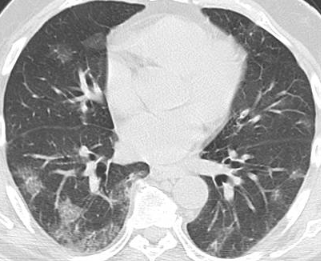

In [37]:
img

We'll load the image processor and model from the hub (here, we use the [Auto Classes](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForImageClassification), which will make sure the appropriate classes will be loaded automatically based on the `config.json` and `preprocessor_config.json` files of the repo on the hub):

In [38]:
from transformers import AutoModelForImageClassification, AutoImageProcessor

repo_name = "ArthurMor4is/vit-base-patch16-224-finetuned-dataset-covid-0"

image_processor = AutoImageProcessor.from_pretrained(repo_name)
model = AutoModelForImageClassification.from_pretrained(repo_name)

In [39]:
# prepare image for the model
encoding = image_processor(img.convert("RGB"), return_tensors="pt")
print(encoding.pixel_values.shape)

torch.Size([1, 3, 224, 224])


In [40]:
encoding.pixel_values

tensor([[[[-0.5294, -0.5216, -0.5059,  ..., -0.4824, -0.4667, -0.4745],
          [-0.5059, -0.4980, -0.4980,  ..., -0.5059, -0.4745, -0.4902],
          [-0.4980, -0.4824, -0.5137,  ..., -0.5059, -0.4667, -0.4824],
          ...,
          [ 0.6863,  0.7255,  0.7725,  ...,  0.6000,  0.6078,  0.6078],
          [ 0.8667,  0.7961,  0.7882,  ...,  0.6235,  0.6471,  0.6627],
          [ 0.8745,  0.8980,  0.8588,  ...,  0.6157,  0.6235,  0.6157]],

         [[-0.5294, -0.5216, -0.5059,  ..., -0.4824, -0.4667, -0.4745],
          [-0.5059, -0.4980, -0.4980,  ..., -0.5059, -0.4745, -0.4902],
          [-0.4980, -0.4824, -0.5137,  ..., -0.5059, -0.4667, -0.4824],
          ...,
          [ 0.6863,  0.7255,  0.7725,  ...,  0.6000,  0.6078,  0.6078],
          [ 0.8667,  0.7961,  0.7882,  ...,  0.6235,  0.6471,  0.6627],
          [ 0.8745,  0.8980,  0.8588,  ...,  0.6157,  0.6235,  0.6157]],

         [[-0.5294, -0.5216, -0.5059,  ..., -0.4824, -0.4667, -0.4745],
          [-0.5059, -0.4980, -

In [41]:
import torch

# forward pass
with torch.no_grad():
    outputs = model(**encoding)
    logits = outputs.logits

In [42]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: CT_COVID


Looks like our model got it correct!

## Pipeline API

An alternative way to quickly perform inference with any model on the hub is by leveraging the [Pipeline API](https://huggingface.co/docs/transformers/main_classes/pipelines), which abstracts away all the steps we did manually above for us. It will perform the preprocessing, forward pass and postprocessing all in a single object.

Let's showcase this for our trained model:

In [43]:
from transformers import pipeline

pipe = pipeline("image-classification", "ArthurMor4is/vit-base-patch16-224-finetuned-dataset-covid-0")

In [44]:
pipe(img)

[{'score': 0.681962251663208, 'label': 'CT_COVID'},
 {'score': 0.3180377781391144, 'label': 'CT_NonCOVID'}]

As we can see, it does not only show the class label with the highest probability, but does return the top 5 labels, with their corresponding scores. Note that the pipelines also work with local models and mage processors:

In [45]:
pipe = pipeline("image-classification",
                model=model,
                feature_extractor=image_processor)

In [46]:
pipe(img)

[{'score': 0.681962251663208, 'label': 'CT_COVID'},
 {'score': 0.3180377781391144, 'label': 'CT_NonCOVID'}]